## 파일 설명
| 파일명 | 파일 용도 | 관련 절 | 페이지 |
|:--   |:--      |:--    |:--      |
| gradient_1d.py | 수치 미분으로 기울기를 구합니다. | 4.3.2 수치 미분의 예 | 125 |
| gradient_2d.py | 수치 미분으로 기울기를 구합니다(두 편미분을 동시에 계산). | 4.4 기울기 | 129 |
| gradient_method.py | 경사하강법의 갱신 과정을 보여줍니다. | 4.4.1 경사법(경사 하강법) | 132 |
| gradient_simplenet.py | simpleNet 클래스 | 4.4.2 신경망에서의 기울기 | 134 |
| train_neuralnet.py | 미치배치 방식으로 학습하고 시험 데이터로 평가합니다. | 4.5.2 미니배치 학습 구현하기 / 4.5.3 시험 데이터로 평가하기 | 141, 143 |
| two_layer_net.py | 2층 신경망 클래스 | 4.5.1 2층 신경망 클래스 구현하기 | 137 |

## 4장 신경망 학습
이번 장의 주제는 신경망 학습입니다. 여기서 **학습**이란 훈련 데이터로부터 가중치 매개변수의
최적값을 자동으로 획득하는 것을 뜻합니다. 이번 장에서는 신경망이 학습할 수 있도록 해주는
**지표**인 손실 함수를 소개합니다. 이 손실 함수의 결과값을 가장 작게 만드는 가중치 매개변수를
찾는 것이 학습의 목표입니다. 이번 장에서는 손실 함수의 값을 가급적 작게 만드는 기법으로,
함수의 기울기를 활용하는 경사법을 소개합니다.

# 4.1 데이터에서 학습한다
## 4.1.1 데이터 주도 학습
#### 특징(Feature) : 입력데이터에서 본질적인 데이터를 정확하게 추출할 수 있도록 설계된 변환기  이미지의 특징 : 벡터로 기술(i.e. 이미지를 벡터로 변환한다), 
#### SVM, KNN과 같은 기계학습에서는 SIFT, SURF, HOG 등의 특징을 사용  딥러닝에서는 특징 학습에서 사람이 개입할 여지가 없다(end-to-end).

<img style="float: left;" src="equations_and_figures/fig%204-2.png" width="550">

## 4.1.2 훈련 데이터와 시험 데이터
#### 훈련 모델의 범용성을 위하여 훈련 데이터와 시험 데이터를 나눈다.
#### 학습 데이터와 다른 데이터에 적용해도 올바른 결과가 나오는지 여부
#### 오버피팅 : 특정 데이터에만 지나치게 최적화되어 다른 데이터에는 적용할 수 없는 경우

# 4.2 손실함수 (Loss function)
#### 현재의 신경망이 훈련 데이터를 얼마나 잘 처리하지 못하느냐(손실)를 나타내는 지표. 
## 4.2.1 평균 제곱 오차
$ E = \displaystyle \frac{1}{2}\displaystyle \sum_{\substack{k}} (y_k - t_k)^2 $
##### $y_k$ 신경망의 출력, $t_k$ 정답레이블, k 데이터 차원 수

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # One-hot encoding

In [4]:
def mean_squared_error(y, t):
    #return 0.5*np.sum((y-t)**2)
    return 0.5*np.sum(np.square(y-t))

In [5]:
mean_squared_error(np.array(y), np.array(t))

0.09750000000000003

## 4.2.2 교차 엔트로피 오차
$ E = \displaystyle - \sum_{\substack{k}} t_k \ln y_k $
##### $y_k$ 신경망의 출력, $t_k$ 정답레이블, k 데이터 차원 수
<img style="float: left;" src="equations_and_figures/fig%204-3.png" width="400">


In [7]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))

In [8]:
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [9]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

## 4.2.3 미니배치 학습
$ E = \displaystyle - \frac{1}{N} \sum_{\substack{n}} \sum_{\substack{k}} t_{nk} \ln y_{nk} $
#### MNIST dataset의 training set이 60,000개이고, 그 모든 데이터를 한꺼번에 집어넣고 손실함수의 합을 구하려면 시간이 걸린다. 더 나아가 빅데이터 수준이 되면 모든 데이터를 한번에 학습시키기는 불가능하다.
#### 따라서 훈련 데이터 중에서 무작위로 일부만 골라 학습을 수행하고 그 일부를 미니배치라고 한다

In [10]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [13]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [14]:
np.random.choice(60000, 10)

array([41884, 31230, 38963,  7731,  1252, 57726, 15228, 24381, 50585,
       11299])

### 4.2.4 (배치용) 교차 엔트로피 오차 구현하기

In [15]:
# 정답 레이블이 one-hot encoding일 때

def cross_entropy_error(y, t):
    if y.ndim == 1: # 데이터가 하나인 경우
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y))/batch_size  # 정답(t)이 0이면 교차 엔트로피 오차도 자연스럽게 0이 된다

In [16]:
# 정답 레이블이 숫자로 주어졌을 때

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size),t]))/batch_size
# np.arange(batch_size)는 0부터 batch_size-1까지 numpy array를 만든다
# t는 레이블이 저장된 list
# y[np.arange(batch_size),t]는 각 데이터의 정답 레이블에 해당하는 신경망의 출력값을 추출한다.

### 4.2.5 왜 손실 함수를 설정하는가?
#### 순방향 전파(Feed forward)로 나온 출력층(예측값)은 다음과 같다. 여기서 f는 활성화 함수이고, h는 은닉층을 구성하는 노드들을 의미한다
$ y_k = \displaystyle f(\sum_{\substack{k}} (w_k^h h_k)) $
####  그 다음 예측값과 실제값의 차이인 에러를 구하고, 정확히는 에러의 최소평균제곱을 구하고 이를 가중치에 대한 미분값을 구한다. 손실함수 E를 Remind 해보자
$ E = \displaystyle \frac{1}{2}\displaystyle \sum_{\substack{k}} (y_k - t_k)^2 $
#### 손실함수를 가중치 w로 미분을 하자
$ \displaystyle \frac{\partial{E}}{\partial{w_k^h}} = -(y_k - t_k)\frac{\partial{t_k}}{\partial{w_k^h}} = -(y_k - t_k)f'(\sum_{\substack{k}} (w_k^h h_k))h_k $
#### 여기서 구한 미분값은 가중치를 업데이트하는데 사용된다. 업데이트는 항상 출력층에서부터 시작하여 feed forward의 반대인 역방향으로 진행된다(back propagation)
#### 가중치를 업데이트할 때는 앞 단계에서 계산된 에러의 최소제곱평균의 미분값을 이용하여 학습률(learning rate)를 선정한 후 학습률만큼 수정된 가중치를 도출한다.
$ w_k^h = w_k^h - \displaystyle \alpha \frac{\partial{E}}{\partial{w_k^h}} = w_k^h + \alpha(y_k - t_k)f'(\sum_{\substack{k}} (w_k^h h_k))h_k $
#### 이제 책 119쪽의 설명으로 돌아와서 보면 신경망 학습에서 최적의(손실함수의 값을 최소화하는) 매개변수 값을 찾기 위해서 미분을 하게 되고, 정확도를 지표로 삼으면 손실함수의 미분이 대부분의 장소에서 0이 된다고 한다. 그리고 120쪽에서 보충설명을 하면서 정확도는 그 값이 불연속적으로 변하는 특성이 있으므로 계단함수(step function)을 활성화함수로 사용하지 않는 이유와 일맥상통한다고 한다. 

<img style="float: left;" src="equations_and_figures/fig%204-4.png" width="600">


# 4.3 수치 미분
## 4.3.1 미분
$ \displaystyle \frac{df(x)}{dx} = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$
<img style="float: left;" src="equations_and_figures/fig%204-5.png" width="400">

In [18]:
np.float32(1e-50)  # 1e-50은 32비트 부동소수점으로 나타내면 0.0이 되어 반올림 오차문제를 일으킨다.
# 따라서 해석적인 미분을 컴퓨터로 구현할 수 없고, numerically 미분의 근사치를 구해야 한다.

0.0

In [19]:
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h) #중심 차분, 중앙 차분

- 수치 미분 : 아주 작은 차분으로 미분하는 것
- 해석적 미분 : 수식을 전개해 미분, 진정한 미분 값

## 4.3.2 수치 미분의 예
#### 아래의 함수를 미분해 보자
$ \displaystyle y = 0.01x^2 + 0.1x $

In [20]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

0.1999999999990898


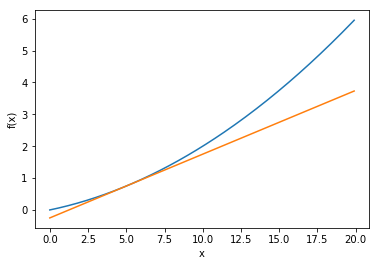

In [21]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

### 4.3.3 편미분
$ \displaystyle f(x_0, x_1) = x_0^2 + x_1^2 $
<img style="float: left;" src="equations_and_figures/fig%204-8.png" width="400">

In [22]:
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

$ \displaystyle f(x_0, x_1) = x_0^2 + x_1^2 $
#### 문제 1: $ x_0 = 3, x_1 = 4 $일 때, $ x_0 $에 대한 편미분 $ \frac{\partial f}{\partial x_0} $를 구하라

In [23]:
def function_tmp1(x0):
    return np.square(x0) + np.power(4.0, 2.0)

numerical_diff(function_tmp1, 3.0)

6.00000000000378

#### 문제 2: $ x_0 = 3, x_1 = 4 $일 때, $ x_1 $에 대한 편미분 $ \frac{\partial f}{\partial x_1} $를 구하라

In [24]:
def function_tmp2(x1):
    return np.power(3.0, 2.0) + np.square(x1)

numerical_diff(function_tmp2, 4.0)

7.999999999999119

## 4.4 기울기
$ \displaystyle \nabla f = \left(\frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1}, \dots , \frac{\partial f}{\partial x_k}\right) $
#### 기하학적으로는 함수 f의 가장 가파른 접선(tangent) 벡터를 의미한다. 기울기(gradient)는 경사하강법에 사용된다

In [25]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad

In [26]:
_numerical_gradient_no_batch(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [27]:
_numerical_gradient_no_batch(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [28]:
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

No handles with labels found to put in legend.


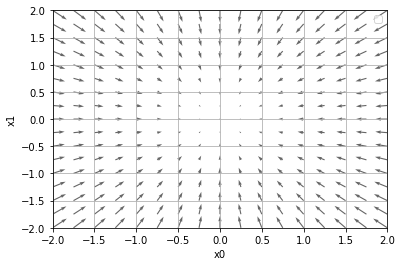

In [29]:
if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.legend()
    plt.draw()
    plt.show()

### 4.4.1 경사 하강법
#### 경사 하강법은 최적화 문제에서 Local Minima(극소값)를 구하는 데 사용되는 가장 보편적인 알고리즘이다. 위에서 살펴봤는데 여기서는 책의 notation에 따라 다시 표현해보자. 위에서의 가중치 w를 여기서는 x로, 손실함수 E를 여기서는 f로, 학습률 $\alpha$를 여기서는 $\eta$로 바꾼 것에 불과하다.
#### 경사 하강법은 임의의 시작점에서 임의의 크기만큼 반복적으로 보정하면서 극소값으로 접근하는 방법으로 말할 수 있고, 극소값이 global minimum이면 정확한 해가 된다. 우리는 극소값에 가장 근접한 근사해를 구하는 것이 목적이다. 아래 수식에서 i는 반복 횟수를 의미한다.
$ x(i+1) = x(i) + \delta x(i)$
#### 경사 하강법의 핵심은 $\delta x(i)$를 구하는 것이다. $\delta x(i)$는 벡터이므로 크기와 방향이 필요하다. 방향은 바로 위에서 다루었던 gradient이며, 크기는 i단계에서 다음 단계인 i+1까지 어느만큼의 거리로 이동할 것인가이다. 따라서 $\delta x(i)$ 크기를 결정할 때에는 gradient 벡터가 갖는 크기에 추가적인 보정이 필요하다. 그 보정 방법이 바로 학습률이다.
$ x_0 = x_0 - \eta \displaystyle \frac{\partial f}{\partial x_0} \\ x_1 = x_1 - \eta \displaystyle \frac{\partial f}{\partial x_1} $

![fig](../deep_learning_images/Figure_fn.png)

In [31]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

#### 문제 : 경사법으로 $ f(x_0,x_1) = x_0^2 + x_1^2 $의 최소값을 구하여라

In [32]:
init_x = np.array([-3.0,4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

(array([-6.11110793e-10,  8.14814391e-10]),
 array([[-3.00000000e+00,  4.00000000e+00],
        [-2.40000000e+00,  3.20000000e+00],
        [-1.92000000e+00,  2.56000000e+00],
        [-1.53600000e+00,  2.04800000e+00],
        [-1.22880000e+00,  1.63840000e+00],
        [-9.83040000e-01,  1.31072000e+00],
        [-7.86432000e-01,  1.04857600e+00],
        [-6.29145600e-01,  8.38860800e-01],
        [-5.03316480e-01,  6.71088640e-01],
        [-4.02653184e-01,  5.36870912e-01],
        [-3.22122547e-01,  4.29496730e-01],
        [-2.57698038e-01,  3.43597384e-01],
        [-2.06158430e-01,  2.74877907e-01],
        [-1.64926744e-01,  2.19902326e-01],
        [-1.31941395e-01,  1.75921860e-01],
        [-1.05553116e-01,  1.40737488e-01],
        [-8.44424930e-02,  1.12589991e-01],
        [-6.75539944e-02,  9.00719925e-02],
        [-5.40431955e-02,  7.20575940e-02],
        [-4.32345564e-02,  5.76460752e-02],
        [-3.45876451e-02,  4.61168602e-02],
        [-2.76701161e-02,  3.689

In [ ]:
def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

In [ ]:
init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)


fig=plt.figure(1)
ax=fig.add_subplot(1,1,1)
plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
circ=plt.Circle((0,0), radius=1, color='b', fill=False)
circ2=plt.Circle((0,0), radius=2, color='b', fill=False)
circ3=plt.Circle((0,0), radius=3, color='b', fill=False)
circ4=plt.Circle((0,0), radius=4, color='b', fill=False)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-4.5, 4.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()